<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/3_Telegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estruturação de aplicação para detecção de notícias a partir da extração de mensagens em grupo do Telegram

Agora que o modelo já foi treinado é preciso analisar a performance dele em tempo real. Em parceria com um órgão do XX, a fração de D&A recebeu informações sobre um grupo de Telegram em que há suspeita de desinformação. Quando estiver em posse do modelo treinado, a equipe pode buscar representantes do desafio para obter o link do grupo.
O engenheiro de dados deverá desenvolver aplicação que acompanha constantemente o grupo designado. Na ocorrência de uma mensagem nesse grupo, a aplicação deverá:

i) preprocessar o texto da mesma forma que na etapa 1;

ii) carregar os parâmetros do modelo treinado na etapa 2;

iii) realizar inferência no texto processado, gerando previsão de se a notícia é falsa ou não;

iv) salvar o texto, o timestamp de recebimento da mensagem, o timestamp após a realização da inferência e a previsão do modelo para aquela notícia em um pandas dataframe;

v) ao fim do recebimento das mensagens (será indicado ao grupo), deverá salvar o pandas dataframe em formato .csv.

Recomenda-se a utilização da biblioteca python telethon, que é assíncrona (deve ser utilizada conjuntamente à biblioteca asyncio). É possível utilizar a biblioteca no Google Colab (nesse caso, deve utilizar ainda o nest_asyncio). Para utilizar a biblioteca telethon é necessário também obter os dados da API do Telegram, que pode ser feito utilizando esse link (https://core.telegram.org/api/obtaining_api_id).

Serão considerados na avaliação: intervalo de tempo entre o recebimento da mensagem e a realização da inferência; eficiência do código.

Importação das bibliotecas

In [ ]:
import pandas as pd
from datetime import datetime

#https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/kafka.ipynb

!pip install tensorflow-io
!pip install kafka-python

import tensorflow as tf
import tensorflow_io as tfio
import time
import threading
from kafka.admin import KafkaAdminClient,NewTopic
from kafka import KafkaProducer
from kafka import KafkaConsumer
from kafka.errors import KafkaError
from sklearn.model_selection import train_test_split
import os
import threading



#Extração das mensagens do grupo do telegram
!pip install Telethon
from telethon import TelegramClient, events
from telethon import utils

import asyncio
import nest_asyncio

import json

# Pré-processamento
import nltk
from nltk.stem import RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#Utilizado para carregar o classificador
import gzip
import pickle
!pip install openpyxl
import openpyxl


#Biblioteca utilizadas para o processamento da linguagem
import spacy
from spacy.lang.pt.examples import sentences

from spacy.tokenizer import Tokenizer
from spacy.lang.pt import Portuguese
import re
from collections import Counter

!pip install Unidecode
from unidecode import unidecode

!pip install yake
import yake

#Baixa o corpus utilizado na próxima análise
# Referência: https://spacy.io/models/pt#pt_core_news_md
# Observação:tem a opção de carregar datasets maiores
!spacy download pt_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.8/568.8 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for Telethon: filename=Telethon-1.33.0-py3-none-any.whl size=640886 sha256=aed7fd2ceea220a231ce1312b70e358f39bc8e44599c23e6e18f7e773808518b
  Stored in directory: /root/.cache/pip/wheels/f6/2a/ce/8d4a70c27c49d4cfd7e38bff8aae2b0ac8990011cfe28e1ca8
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26346 sha256=88cc75d60c4d8443b9fc7463576b8c2e239c63c4518b01f11bf0c62afea0a752
  Stored in directory: /root/.cache/pip/wheels/d6/84/5f/ea6aef85a93c7e1922486369874f4740a5642d261e09c59140
Successfully built Telethon pyaes
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

#Download e setup do Kafka e zookeeper
!curl -sSOL https://archive.apache.org/dist/kafka/3.1.0/kafka_2.13-3.1.0.tgz


In [ ]:
!tar -xzf kafka_2.13-3.1.0.tgz

In [ ]:
!./kafka_2.13-3.1.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.1.0/config/zookeeper.properties
!./kafka_2.13-3.1.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.1.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
#Verifica o processo do kafka rodando na máquina
!ps -ef | grep kafka

root        1932     242  0 21:04 ?        00:00:00 /bin/bash -c ps -ef | grep kafka
root        1934    1932  0 21:04 ?        00:00:00 grep kafka


In [ ]:
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id='Datathon')

# Nome do tópico do Kafka utilizado na leitura em streaming
topic_name="new-message"
#admin_client.delete_topics(topics=[topic_name])

new_topic = NewTopic(name=topic_name, num_partitions= 5, replication_factor=1)
topic_list = []
topic_list.append(new_topic)

#admin_client.create_topics(new_topics=topic_list)

Extração dos textos do grupo de telegram

Realizei os seguintes passos para obter as credenciais de acesso do Telegram:

1) Acessei o site [my.telegram.org](https://);

2) Informei o número do meu celular;

3) Recebi um código de verificação;

4) Digitei o código de verificação no site;

5) Acessei a opção "API development tools", preenchi o formulário conforme
imagem abaixo;

6) Cliquei em "Create application";

7) Recebi o App api_id e o App api_hash.

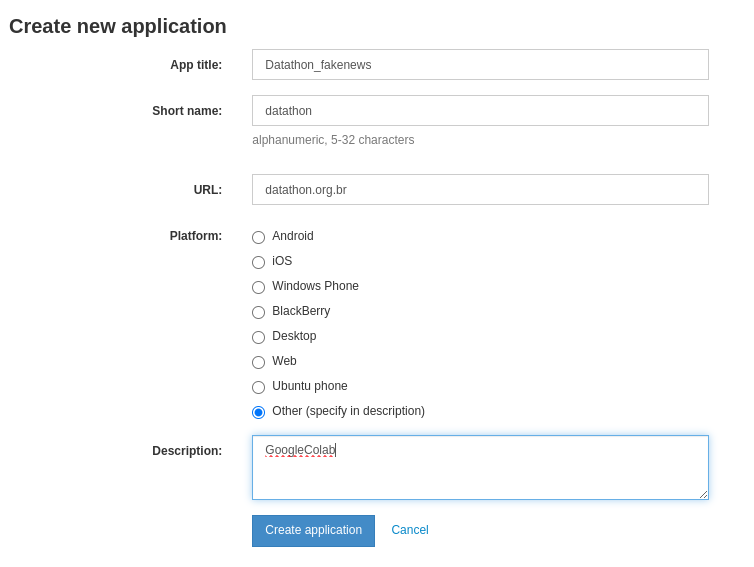

Referências:
https://www.itpanther.com/scrape-telegram-group-messages/
https://arabic-telethon.readthedocs.io/en/stable/extra/examples/telegram-client.html#getting-messages

In [ ]:
#Leitura das credenciais de acesso ao telegram
file_path = "/content/telegram_app_configuration.json"
try:
  with open(file_path, 'r') as f:
    app_config = json.load(f)
    api_id=app_config["api_id"]
    api_hash=app_config["api_hash"]
    phone_number=app_config["phone_number"]
    token_bot=app_config["token_bot"]
    print("Carregou as credenciais do telegram com sucesso.")
except Exception as error:
  print("Falha ao carregar as credenciais do telegram.")
  print("É necessário fazer upload do arquivo de credenciais no google colab.")
  print(f"Exceção: {error} ")

Carregou as credenciais do telegram com sucesso.


In [ ]:
#Imprime o número de celular presente no arquivo de configuração
print("Phone Number: ",phone_number)

Phone Number:  5561998210957


In [ ]:
async def get_chat_ids(client):
  async for dialog in client.iter_dialogs():
    if dialog.is_channel or dialog.is_group:
      print(f"{dialog.title}:{int(dialog.id)}")


nest_asyncio.apply()
async with TelegramClient('datathon', api_id, api_hash) as client:
  client.loop.run_until_complete(get_chat_ids(client))

TesteDatathon1:-1002141343872
datathon_equipe3:-4043521267
TesteDatathon1:-4030344137
Thiago and Um Pé:-4083684181


In [ ]:
#chat = "jairbolsonarobrasil"
#chat = "gconoticias"
chat = -1002141343872 #TesteDatathon1
#chat = -4043521267 #datathon_equipe3

In [ ]:
#Cria o produtor de mensagens do Kafka
producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'], value_serializer=lambda v: json.dumps(v).encode('utf-8'))
#producer.close()

Monitora as mensagens em tempo real

In [ ]:
def extrai_informacoes_evento(event,client):
  event_dict = event.to_dict()
  message_dict = event_dict["message"].to_dict()
  if (message_dict['message'] == "LOGOUT"):
    client.disconnect()

  print(message_dict['date'])
  print(message_dict['message'])
  print(message_dict['from_id']['user_id'])
  message_json = json.dumps(message_dict, indent = 4,sort_keys=True, default=str)
  producer.send(topic_name, message_json)
  producer.flush()

In [ ]:
# Dispara o recebimento de mensagens em tempo real
# Referência: https://arabic-telethon.readthedocs.io/en/stable/extra/basic/working-with-updates.html
async def get_new_messages(api_id, api_hash):
  nest_asyncio.apply()
  async with TelegramClient('datathon', api_id, api_hash) as client:
    @client.on(events.NewMessage)
    async def trata_novas_mensagens(event):
      try:
        await extrai_informacoes_evento(event,client)
      except Exception as e:
        #Pendência tratar exceção
        print(e)
        pass
    try:
      await client.run_until_disconnected()
    except Exception as e:
      #Pendência tratar exceção
      print(e)
      pass



In [ ]:
# Cria um thread para ficar recebendo as mensagens em background
def run_get_new_messages(api_id, api_hash):
  asyncio.run(get_new_messages(api_id, api_hash))

thread_produtor = threading.Thread(target=run_get_new_messages, name="streaming", args=[api_id, api_hash])
thread_produtor.start()

In [ ]:
#Verifica se a thread ainda está sendo executada
thread_produtor.is_alive()


True

In [ ]:
def classifica_novo_texto(model_name, news_text):
  #Carrega o modelo treinado
  file_name = model_name+'.pkl'
  file_path="/content/"+file_name
  try:
    with open(file_path, 'rb') as f:
      model = pickle.load(f)
      #Classifica o novo texto com o modelo
      classificacao = model.predict(news_text)
      return classificacao[0]
  except Exception as error:
    print("Falha ao carregar o modelo treinado.")
    print(f"Exceção: {error} ")

In [ ]:
#Baixa o modelo treinado
model_name = "RFC"
url = "https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/"+model_name+".pkl"
!wget $url

--2023-12-03 21:05:33--  https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/RFC.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/RFC.pkl [following]
--2023-12-03 21:05:33--  https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/RFC.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10391204 (9.9M) [application/octet-stream]
Saving to: ‘RFC.pkl’

RFC.pkl             100%[===================>]   9.91M  --.-KB/s    in 0.1s    

2023-12-03 21:05:34 (80.4 MB/s) - ‘RFC.pkl’ saved [10391204/10391204]



In [ ]:
#metadata3 = category
def get_category(text):
  language = "pt"
  max_ngram_size = 1
  deduplication_threshold = 0.9
  deduplication_algo = 'seqm'
  windowSize = 1
  numOfKeywords = 5

  custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
  keywords_set = custom_kw_extractor.extract_keywords(text)
  keywords = []
  for kw in keywords_set:
    keywords.append(kw[0])
  return str(keywords)



In [ ]:
# metadata5 = number of tokens
def get_num_tokens(nlp_pt,text):
  #Uma abordagem mais simples
  #tokens = text.split()
  #return len(tokens)

  #Adiciona esse parâmetro para contar ponto-final.
  suffix_re = re.compile(r'''\.$''')
  tokenizer = Tokenizer(nlp_pt.vocab, suffix_search=suffix_re.search)

  tokens = tokenizer(text)
  return len(tokens)



In [ ]:
 #metadata6 = number of words without punctuation
 def get_number_words_without_punctuation(doc_pt):
  num_words = 0
  for token in doc_pt:
    if not token.is_punct:
      token_original = str(token)
      token_decode = unidecode(token_original)
      if token_decode == token_original:
        num_words = num_words + 1
  return num_words




In [ ]:
 #metadata7 = number of types
def get_num_palavras_unicas(doc_pt):
  words = set()
  for token in doc_pt:
    token_str = str(token)
    result = re.search("[a-z]+", token_str, re.IGNORECASE)
    if result is not None:
      words.add(token_str)
  return len(words)



In [ ]:
# metadata9 = number of words in upper case
def get_number_words_in_upper_case(doc_pt):
  num_words = 0
  for token in doc_pt:
    if token.is_upper:
      num_words = num_words + 1
  return num_words



In [ ]:
#  metadata10 = number of verbs
def get_number_of_verbs(doc_folha):
  num_verbs = 0
  for token in doc_folha:
    if token.pos_ == 'VERB':
      num_verbs = num_verbs + 1
  return num_verbs



In [ ]:
#metadata12 = number of nouns
def get_number_nouns(doc_folha):
  num_nouns = 0
  for token in doc_folha:
    if token.pos_ == 'NOUN':
      num_nouns = num_nouns + 1
  return num_nouns



In [ ]:
 #metadata13 = number of adjectives
def get_number_adjectives(doc_folha):
  number_adjectives = 0
  for token in doc_folha:
    if token.pos_ == 'ADJ':
      number_adjectives = number_adjectives + 1
  return number_adjectives



In [ ]:
# metadata14 = number of adverbs
def get_number_adverbs(doc_folha):
  number_adverbs = 0
  for token in doc_folha:
    if token.pos_ == 'ADV':
      number_adverbs = number_adverbs + 1
  return number_adverbs



In [ ]:
#  metadata15 = number of modal verbs (mainly auxiliary verbs)
# Pendência: contando apenas os verbos auxiliares

def get_auxiliary_verbs(doc_folha):
  number_auxiliary_verbs = 0
  for token in doc_folha:
    if token.pos_ == 'AUX':
      number_auxiliary_verbs = number_auxiliary_verbs + 1
  return number_auxiliary_verbs



In [ ]:
#  metadata16 = number of singular first and second personal pronouns
# Primeira pessoa do singular: eu, me, mim, comigo
# Segunda pessoa do singular: tu, te, ti, contigo
def get_first_second_personal_pronouns(doc_folha):
  number_pronouns = 0
  for token in doc_folha:
    if token.pos_ == 'PRON':
      if str(token).lower() in ["eu", "me", "mim", "comigo", "tu", "te", "ti", "contigo"]:
        number_pronouns = number_pronouns + 1
  return number_pronouns



In [ ]:
def get_personal_pronouns(doc_folha):
  number_pronouns = 0
  for token in doc_folha:
    if token.pos_ == 'PRON':
      if str(token).lower() in ["nós", "nos", "conosco"]:
        number_pronouns = number_pronouns + 1
  return number_pronouns



In [ ]:
#  metadata18 = number of pronouns
def get_num_pronouns(doc_folha):
  number_pronouns = 0
  for token in doc_folha:
    if token.pos_ == 'PRON':
      number_pronouns = number_pronouns + 1
  return number_pronouns



In [ ]:
def get_num_sentencas(text):
  result = re.findall("[(.|?|!)*]+", text, re.IGNORECASE)
  num_sentencas = len(result)
  return num_sentencas

In [ ]:
# metadata19 = pausality
################################
# Pendência: consideramos apenas a vírgula como sinal de pontuação
#################################
def get_pausality(text):
  result = re.findall("[(,)*]+", text, re.IGNORECASE)
  num_virgulas = len(result)
  num_sentencas = get_num_sentencas(text)
  if num_sentencas == 0:
    pausality = 0
  else:
    pausality = num_virgulas / num_sentencas
  return pausality



In [ ]:
#Referência https://spacy.io/api/token
def get_num_palavras(doc_pt):
  num_words = 0
  for token in doc_pt:
    #Estratégia de verificação anterior com o token.is_alpha não reconhecia palavras que estavam fora do corpus
    #if token.is_alpha:
    result = re.search("[a-z]+", str(token), re.IGNORECASE)
    if result is not None:
      num_words = num_words + 1
  return num_words

In [ ]:
#  metadata20 = number of characters
def get_num_caracteres(doc_pt):
  num_caracteres = 0
  for token in doc_pt:
    token_str = str(token)
    result = re.search("[\w]+", token_str, re.IGNORECASE)
    if result is not None:
      num_caracteres = num_caracteres + len(token_str)
  return num_caracteres



In [ ]:
#  metadata21 = average sentence length
def get_tamanho_medio_sentenca(text,doc_pt):
  num_sentencas = get_num_sentencas(text)
  if num_sentencas == 0:
    return 0
  else:
    return get_num_palavras(doc_pt)/num_sentencas



In [ ]:
# metadata22 = average word length
def get_tamanho_medio_palavras(doc_pt):
  num_palavras = get_num_palavras(doc_pt)
  if num_palavras == 0:
    return 0
  else:
    return get_num_caracteres(doc_pt)/num_palavras


In [ ]:
# metadata24 = emotiveness
def get_emotiveness(doc_folha, doc_pt):
  number_of_verbs = get_number_of_verbs(doc_folha)
  if number_of_verbs == 0:
    return 0
  else:
    emotiveness = get_num_palavras(doc_pt) / number_of_verbs
  return emotiveness



In [ ]:
#  metadata25 = diversity
def get_diversity(doc_pt):
  diversity = get_num_palavras_unicas(doc_pt) / get_num_palavras(doc_pt)
  return diversity



In [ ]:
# metadata26 = incerteza
# Pendente: a função que obtém os verbos modais e auxiliares está obtendo apenas os auxiliares
def get_incerteza(doc_folha,doc_pt):
  num_palavras = get_num_palavras(doc_pt)
  incerteza = 0
  if num_palavras != 0:
    incerteza = get_auxiliary_verbs(doc_folha) / num_palavras
  return incerteza




In [ ]:
#Utilizado para obter os próximos metadados
nlp_pt = Portuguese()
#Podemos analisar as classes gramaticais das palavras utilizadas nos textos verdadeiros e falsos
nlp_folha = spacy.load("pt_core_news_md")

def enriquece_metadados(df,nlp_pt,nlp_folha):
  df["doc_pt"] = df.apply(lambda x: nlp_pt(x.text) , axis=1)
  df["doc_folha"] = df.apply(lambda x: nlp_folha(x.text) , axis=1)
  df["metadata3"] = df.apply(lambda x: get_category(x.text) , axis=1)
  df["metadata5"] = df.apply(lambda x: get_num_tokens(nlp_pt,x.text), axis=1)
  df["metadata6"] = df.apply(lambda x: get_number_words_without_punctuation(x.doc_pt), axis=1)
  df["metadata7"] = df.apply(lambda x: get_num_palavras_unicas(x.doc_pt), axis=1)
  df["metadata8"] = df.apply(lambda x: "Pendente", axis=1)
  df["metadata9"] = df.apply(lambda x: get_number_words_in_upper_case(x.doc_pt), axis=1)
  df["metadata10"] = df.apply(lambda x: get_number_of_verbs(x.doc_folha), axis=1)
  df["metadata11"] = df.apply(lambda x: "Pendente", axis=1)
  df["metadata12"] = df.apply(lambda x: get_number_nouns(x.doc_folha), axis=1)
  df["metadata13"] = df.apply(lambda x: get_number_adjectives(x.doc_folha), axis=1)
  df["metadata14"] = df.apply(lambda x: get_number_adverbs(x.doc_folha), axis=1)
  df["metadata15"] = df.apply(lambda x: get_auxiliary_verbs(x.doc_folha), axis=1)
  df["metadata16"] = df.apply(lambda x: get_first_second_personal_pronouns(x.doc_folha), axis=1)
  df["metadata17"] = df.apply(lambda x: get_personal_pronouns(x.doc_folha), axis=1)
  df["metadata18"] = df.apply(lambda x: get_num_pronouns(x.doc_folha), axis=1)
  df["metadata19"] = df.apply(lambda x: get_pausality(x.text), axis=1)
  df["metadata20"] = df.apply(lambda x: get_num_caracteres(x.doc_pt), axis=1)
  df["metadata21"] = df.apply(lambda x: get_tamanho_medio_sentenca(x.text,x.doc_pt), axis=1)
  df["metadata22"] = df.apply(lambda x: get_tamanho_medio_palavras(x.doc_pt), axis=1)
  df["metadata23"] = "Pendente"
  df["metadata24"] = df.apply(lambda x: get_emotiveness(x.doc_folha,x.doc_pt), axis=1)
  df["metadata25"] = df.apply(lambda x: get_diversity(x.doc_pt), axis=1)
  df["metadata26"] = df.apply(lambda x: get_incerteza(x.doc_folha, x.doc_pt), axis=1)
  return df

In [ ]:
def sort_drop_columns(df):
  #após acabar de calcular os metadados apagar as colunas doc_pt e doc_folha
  df = df.drop(columns=["doc_pt","doc_folha"])

  #Reordenar as colunas para ficar de acordo com a planilha
  df = df.reindex(columns=['received_timestamp', 'inference_timestamp','predicted_label','text',
  'metadata1', 'metadata2', 'metadata3','metadata4','metadata5',
  'metadata6', 'metadata7', 'metadata8', 'metadata9', 'metadata10',
  'metadata11', 'metadata12', 'metadata13','metadata14', 'metadata15',
  'metadata16','metadata17', 'metadata18', 'metadata22', 'metadata23',
  'metadata24','metadata25', 'metadata26'])
  return df

In [ ]:
Primeira_mensagem = True

In [ ]:
def consome_mensagens(consumer,chat,nlp_pt,nlp_folha,model_name,Primeira_mensagem):
  while True:
    for msg in consumer:
      message = json.loads(json.loads(msg.value))

      #Obtém o identificador do chat
      peer_id = message["peer_id"]
      if "chat_id" in peer_id:
        chat_id = peer_id["chat_id"]
      elif "channel_id" in peer_id:
        chat_id = peer_id["channel_id"]
      else:
        chat_id = ""


      data = {"received_timestamp": datetime.now(),
              "text" : message["message"],
              "metadata1":message["from_id"]["user_id"],
              "metadata2":"Pendente",
              "metadata4": message["date"],
              "id": message["id"],
              "chat_id": chat_id,
              "mentioned" : message["mentioned"],
              "media_unread": message["media_unread"],
               "silent": message["silent"],
              "post": message["post"],
              "from_scheduled":message["from_scheduled"],
              "legacy": message["legacy"],
              "edit_hide":message["edit_hide"],
              "pinned": message["pinned"],
              "noforwards": message["noforwards"],
              "invert_media": message["invert_media"],
              "fwd_from":message["fwd_from"],
             "via_bot_id": message["via_bot_id"],
             "reply_to":message["reply_to"],
             "media":message["media"],
             "reply_markup":message["reply_markup"],
             "entities":message["entities"],
             "views":message["views"],
             "forwards":message["forwards"],
             "replies":message["replies"],
             "edit_date":message["edit_date"],
             "post_author":message["post_author"],
             "grouped_id":message["grouped_id"],
             "reactions":message["reactions"],
             "restriction_reason":message["restriction_reason"],
             "ttl_period":message["ttl_period"]
        }

      df = pd.json_normalize(data)
      df["predicted_label"] = df.apply(lambda x:  classifica_novo_texto(model_name, [x["text"]]) , axis=1)
      df["inference_timestamp"] = datetime.now()

      df = enriquece_metadados(df,nlp_pt,nlp_folha)
      df = sort_drop_columns(df)


      filename = "mensagens-"+str(chat)+".csv"
      if Primeira_mensagem == True:
        df.to_csv(filename, mode='a', index=False, header=True)
        Primeira_mensagem = False
      else:
        df.to_csv(filename, mode='a', index=False, header=False)

consumer = KafkaConsumer(topic_name,
                        group_id=None,
                         bootstrap_servers=['localhost:9092'],
                         auto_offset_reset = 'earliest')

#consome_mensagens(consumer,chat,nlp_pt,nlp_folha,model_name,Primeira_mensagem)
thread_consumidor = threading.Thread(target=consome_mensagens, name="Consumidor", args=[consumer,chat,nlp_pt,nlp_folha,model_name,Primeira_mensagem])
thread_consumidor.start()

In [ ]:
thread_consumidor.is_alive()

True

In [87]:
url = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/mensagens-historico.csv"
df_mensagens = pd.read_csv(url)
messages = list(df_mensagens["text"])
print(messages)

['sinal tres poderes republica nao temem possibilidade punicao boca urna dado dias deste mes congresso nacional criou fundo financiamento campanha fazendo unica concessao trocar insultada democracia descricao factual objetivo dinheiro farto melhor piso teto bancar certamente bilionarias campanhas eleitorais dinheiro tungado contribuinte mesma ocasiao turma reunida abrigo cumbuca virada tigela emborcada concedeu membros merce pegar dinheiro emprestado cofres viuva comprometer pagar nao quer dizer pagarao dividas uniao conjunto espoliado povo brasileiro logo seguida votacao decidida voto coluna meio presidente belas frases vazias supremo tribunal federal stf carmen lucia judiciario devolveu nada insignes tambem nada insignificantes parlamentares poder tornarem foro superprivilegio intocaveis antes disso executivo alto poder monarquico havia recorrido expedientes rotina garantir imunidade pe meio chefe concluido processo esvaziamento cofres todos receptaculos suado amarfanhado dinheiro es

In [88]:
# Popula o grupo com notícias
nest_asyncio.apply()
async def send_messages(group_id, messages):
    client = TelegramClient('datathon_insere_mensagens', api_id, api_hash)
    await client.connect()
    await client.start()

    for message in messages:
        print('Sending message!')
        await client.send_message(group_id, message)
        await asyncio.sleep(30)

    await client.disconnect()
messages = []
asyncio.run(send_messages(chat, messages))

Please enter your phone (or bot token): 5561998210957
2023-12-03 21:41:16+00:00
Login code: 74561. Do not give this code to anyone, even if they say they are from Telegram!

This code can be used to log in to your Telegram account. We never ask it for anything else.

If you didn't request this code by trying to log in on another device, simply ignore this message.
777000
object NoneType can't be used in 'await' expression
Please enter the code you received: 74561
Signed in successfully as Thiago Melo; remember to not break the ToS or you will risk an account ban!


In [ ]:
# Popula o grupo com notícias extraídas de outro dataset
#Utiliza notícias pré-processadas
url="https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/pre-processed.csv"
df_send_texts = pd.read_csv(url,on_bad_lines = 'warn')

#Seleciona N notícias aleatórias para enviar no grupo
n = 0
df_aleatorias = df_send_texts.sample(n)

#Tamanho máximo da mensagem a ser enviada
MAX_LEN=4096

async def send_random_messages(client, chat, df_aleatorias):
  for news_text in df_aleatorias["preprocessed_news"]:
    await client.send_message(chat, news_text[:MAX_LEN])

#Esse comando nest_asyncio permite rodar mais de um loop ao mesmo tempo
nest_asyncio.apply()
async with TelegramClient('datathon', api_id, api_hash) as client:
  client.loop.run_until_complete(send_random_messages(client, chat, df_aleatorias))

In [ ]:
# Obtém as mensagens do grupo
# Referências
# Dados obtidos das mensagens: https://core.telegram.org/constructor/message
# Objeto message da biblioteca Telethon: https://docs.telethon.dev/en/stable/quick-references/objects-reference.html#message
# Biblioteca que consume a API do Telegram:
#https://buildmedia.readthedocs.org/media/pdf/telethon/stable/telethon.pdf

async def get_all_messages(client,chat):
  df = pd.DataFrame()
  async for message in client.iter_messages(chat):
    if(str(type(message)) !=  "<class 'telethon.tl.patched.MessageService'>"):
      #Não captura mensagens de serviço, que não são mensagens de usuários
      data = {"received_timestamp": datetime.now(),
              "text" : message.message,
              "metadata1":message.from_id.user_id,
              "metadata2":"Pendente",
              "metadata4": message.date,
              "id": message.id,
              "chat_id": message.peer_id.chat_id,
              "mentioned" : message.mentioned,
              "media_unread": message.media_unread,
               "silent": message.silent,
              "post": message.post,
              "from_scheduled":message.from_scheduled,
              "legacy": message.legacy,
              "edit_hide":message.edit_hide,
              "pinned": message.pinned,
              "noforwards": message.noforwards,
              "invert_media": message.invert_media,
              "fwd_from":message.fwd_from,
             "via_bot_id": message.via_bot_id,
             "reply_to":message.reply_to,
             "media":message.media,
             "reply_markup":message.reply_markup,
             "entities":message.entities,
             "views":message.views,
             "forwards":message.forwards,
             "replies":message.replies,
             "edit_date":message.edit_date,
             "post_author":message.post_author,
             "grouped_id":message.grouped_id,
             "reactions":message.reactions,
             "restriction_reason":message.restriction_reason,
             "ttl_period":message.ttl_period
      }


      temp_df = pd.DataFrame(data, index=[1])
      df = pd.concat([temp_df, df])
  return df

In [ ]:
nest_asyncio.apply()
async with TelegramClient('datathon', api_id, api_hash) as client:
  df = client.loop.run_until_complete(get_all_messages(client, chat))

In [ ]:
if chat == -4043521267:
  #Desconsidera as primeiras duas mensagens
  df = df.iloc[2:]


In [ ]:
#Mostra a quantidade de mensagens que foi obtida e quantas colunas foram preenchidas
df.shape

(100, 32)

Classifica as mensagens obtidas do grupo do telegram

In [ ]:
#Apresenta algumas mensagens
#print(df.head())

In [ ]:
#Classifica as mensagens baixadas
df["predicted_label"] = df.apply(lambda x:  classifica_novo_texto(model_name, [x["text"]]) , axis=1)
df["inference_timestamp"] = datetime.now()

Enriquecimento com as pistas linguísticas

In [ ]:
df = enriquece_metadados(df,nlp_pt,nlp_folha)
df = sort_drop_columns(df)


Persistência do dado em arquivo

In [ ]:
#Gera o arquivo das mensagens no formato csv
tempo = datetime.now().strftime("-%Y-%m-%d-%H:%M:%S")
file_name = "mensagens-"+str(chat)+tempo+".csv"
print(file_name)
df.to_csv(file_name, index=False)

mensagens--4043521267-2023-12-03-21:28:46.csv


In [ ]:
#df_grupos = df[['Identificador_Grupo']]
#df_grupos = df_grupos.rename(columns={"Identificador_Grupo":"Id"})
#df_grupos = df_grupos.drop_duplicates()

df_usuarios = df[['metadata1']]
df_usuarios = df_usuarios.rename(columns={"metadata1":"Id"})
df_usuarios = df_usuarios.drop_duplicates()

In [ ]:
# Obtém o nome do grupo e do usuário emissor da mensagem pelo identificador
#https://docs.telethon.dev/en/stable/modules/utils.html
async def get_name(id):
  async with TelegramClient('datathon', api_id, api_hash) as client:
    entity = await client.get_entity(id)
    nome = utils.get_display_name(entity)
    return nome

In [ ]:
#df_grupos["Nome"] = await asyncio.gather(*(get_name(id) for id in df_grupos['Id']))

In [ ]:
df_usuarios["Nome"] = await asyncio.gather(*(get_name(id) for id in df_usuarios['Id']))

In [ ]:
#Gera o arquivo dos grupos no formato csv
#tempo = datetime.now().strftime("-%Y-%m-%d-%H:%M:%S")
#file_name = "grupos-"+str(chat)+tempo+".csv"
#df_grupos.to_csv(file_name, index=False)


In [ ]:
#Gera o arquivo dos usuários no formato csv
tempo = datetime.now().strftime("-%Y-%m-%d-%H:%M:%S")
file_name = "usuarios-"+str(chat)+tempo+".csv"
df_usuarios.to_csv(file_name, index=False)

i) preprocessar o texto da mesma forma que na etapa 1;

No pré-processamento de linguagem natural é comum retirar palavras sem significado semântico (conhecidas em inglês como "stop words").

In [ ]:
# Stopwords em português:
nltk.download('stopwords')
stopwordspt = nltk.corpus.stopwords.words('portuguese')
stopwordsen = nltk.corpus.stopwords.words('english')
stopwordspt[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

Outro pré-processamento possível é a retirada de prefixos e sufixos desnecessários das palavras ( processo conhecido em inglês pelos termos "lemmatizing and stemming")

In [ ]:
# Download lista de radicais e sufixos
!wget https://github.com/michmech/lemmatization-lists/raw/master/lemmatization-pt.txt -q
nltk.download('rslp')

ptstemmer = RSLPStemmer()
enstemmer = WordNetLemmatizer()

# Convert to dictionary
lmztpt = {}
dic = open("lemmatization-pt.txt")
for line in dic:
  txt = line.split()
  lmztpt[txt[1]] = txt[0]

# Lemmatize wherever possible
def PortugueseMess(word):
  if word in lmztpt.keys():
    return lmztpt.get(word)
  else:
    return ptstemmer.stem(word)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
